In this notebook, we will train and run an autoencoder on some ATLAS data.   

## Look into the dataset

We take a csv dataset, and open into Pandas (after importing pandas).

Each line in the csv corresponds to one event, which consists of variable amounts of particles. We select only the 'j' type particles, corresponding to jets.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

from pathlib import Path
from collections  import OrderedDict
import math

data_path = Path('monojet_Zp2000.0_DM_50.0_chan3.csv')

data = OrderedDict()
with open(data_path, 'r') as f:
        for line in f:            
            split = line.strip().split(';')
            first_five = ''.join(split[0:4])
            objs = split[5:]
            
            jets = []
            for obj in objs:
                split_obj = obj.strip().split(',')                
                if 'j' in split_obj:
                    jets.append([float(i) for i in split_obj[1:]])
                    
            data[first_five] = jets

The data is raw and unnormalized. Several methods of normalization are prepared below. The custom-normalization gives the most accurate results.

In [2]:
combined_jets = [jet for event in data.values() for jet in event]
df = pd.DataFrame.from_records(combined_jets)
df.columns = ["E","pt","eta","phi"]

standard_normalised = pd.DataFrame(StandardScaler().fit_transform(df))
power_normalised = pd.DataFrame(PowerTransformer().fit_transform(df))

def custom_normalize(df):
    df['eta'] = df['eta'] / 5
    df['phi'] = df['phi'] / 3
    df['E'] = (np.log(df['E'] / 1000) - 3.2) / 5
    df['pt'] = (np.log(df['pt'] / 1000) - 3.1) / 4.5
    return df

df = custom_normalize(df)

Now we must separate the data into training and test sets, using a standard split of 30:70

In [3]:
train, test = train_test_split(df, test_size=0.3)


# To get an idea of the order of magnitude we are going to see in the plots we show the first elements 
# in the samples:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
              E        pt       eta       phi
8027   0.733551  0.272184 -0.646894 -0.106584
4183   0.280379  0.304316 -0.101697 -0.644197
4474   0.301549  0.344461  0.059338  0.144198
6364   0.393818  0.458034  0.001112 -0.443497
12517  0.478261  0.023757  0.615048 -0.186829


Testing sample:
              E        pt       eta       phi
17353  0.605980  0.230955 -0.555930 -0.555513
9537   0.307369  0.362107  0.009780  0.178948
18898  0.704561  0.787430  0.079794 -0.065491
5948   0.462074  0.283053 -0.360284  0.896603
9679   0.654250  0.720213 -0.101701 -0.333793


The number of entries in the training data: 15805
The number of entries in the validation data: 6774


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

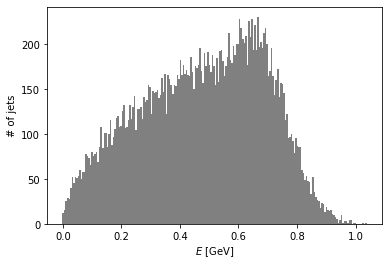

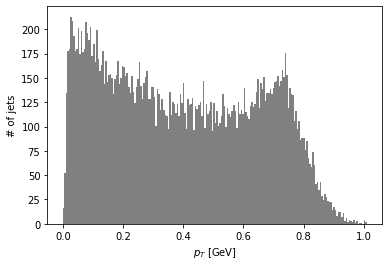

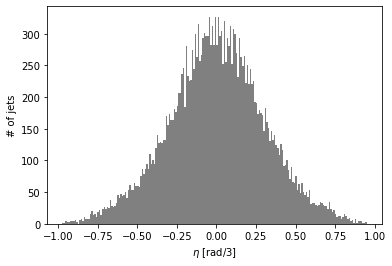

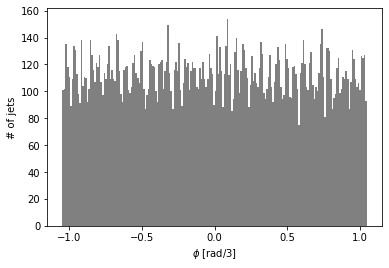

In [4]:
import matplotlib.pyplot as plt

unit_list = ['[GeV]', '[GeV]', '[rad/3]', '[rad/3]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E","pt","eta","phi"]

n_bins = 200

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(df[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of jets')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [6]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have two architectures for the autoencoder network. The first is a straightforward feed-forward with 4-200-100-50-3-50-100-200-4 layers and an ELU activation function.

The second is the same but with batchnormalization layers added between each layer.

In [7]:
class AE_3D_200_ELU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_ELU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.activ = nn.ELU()

    def encode(self, x):
        return self.en4(self.activ(self.en3(self.activ(self.en2(self.activ(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.activ(self.de3(self.activ(self.de2(self.activ(self.de1(self.activ(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'

class AE_3D_200_ELU_BN(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_ELU_BN, self).__init__()
        
        self.activ = nn.ELU()
        
        self.encoder = nn.Sequential(
            nn.Linear(n_features, 200),
            nn.BatchNorm1d(200),
            self.activ,
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            self.activ,
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            self.activ,
            nn.Linear(50, 3)   
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 50),
            nn.BatchNorm1d(50),
            self.activ,
            nn.Linear(50, 100),
            nn.BatchNorm1d(100),
            self.activ,
            nn.Linear(100, 200),
            nn.BatchNorm1d(200),
            self.activ,
            nn.Linear(200, n_features)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'


model = AE_3D_200_ELU()
model.to('cpu')

AE_3D_200_ELU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (activ): ELU(alpha=1.0)
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [8]:
from fastai.metrics import mse

# calculate difference between original and recreated data
loss_func = nn.MSELoss()

# Weight decay - controls bias/variance
wd = 1E-6

recorder = learner.Recorder()
learn = learner.Learner(dls,
                        model=model,
                        wd=wd,
                        wd_bn_bias = False,
                        loss_func=loss_func,
                        cbs=recorder)

## Training the network

First, we want to find the best learning rate. The learning rate is a hyper-parameter that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.002754228748381138
Learning rate with the steepest gradient: 0.009120108559727669


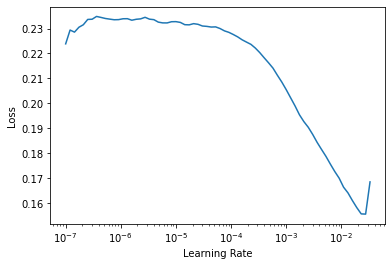

In [9]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [10]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.1211530789732933, 0.06652872264385223, '00:01']
[0, 0.1211530789732933, 0.06652872264385223, '00:01']
[1, 0.06424615532159805, 0.03641482815146446, '00:01']
[1, 0.06424615532159805, 0.03641482815146446, '00:01']
[2, 0.03526889905333519, 0.016370778903365135, '00:01']
[2, 0.03526889905333519, 0.016370778903365135, '00:01']
[3, 0.01420447789132595, 0.00435732351616025, '00:01']
[3, 0.01420447789132595, 0.00435732351616025, '00:01']
[4, 0.006598925217986107, 0.003191258991137147, '00:01']
[4, 0.006598925217986107, 0.003191258991137147, '00:01']
[5, 0.003687644610181451, 0.0018489762442186475, '00:01']
[5, 0.003687644610181451, 0.0018489762442186475, '00:01']
[6, 0.0015073252143338323, 0.00029570842161774635, '00:01']
[6, 0.0015073252143338323, 0.00029570842161774635, '00:01']
[7, 0.0005821881932206452, 0.00018987516523338854, '00:01']
[7, 0.0005821881932206452, 0.00018987516523338854, '00:01']
[8, 0.0003553769493009895, 0.00018525980703998357, '00:01']
[8, 0.0003553769493009895, 0.0

[68, 8.978259756986517e-06, 5.829017027281225e-06, '00:01']
[68, 8.978259756986517e-06, 5.829017027281225e-06, '00:01']
[69, 6.876202405692311e-06, 4.05049831897486e-06, '00:01']
[69, 6.876202405692311e-06, 4.05049831897486e-06, '00:01']
[70, 6.138302069302881e-06, 5.133555987413274e-06, '00:01']
[70, 6.138302069302881e-06, 5.133555987413274e-06, '00:01']
[71, 4.939339305565227e-06, 3.79999232791306e-06, '00:01']
[71, 4.939339305565227e-06, 3.79999232791306e-06, '00:01']
[72, 4.595380687533179e-06, 4.966271262674127e-06, '00:01']
[72, 4.595380687533179e-06, 4.966271262674127e-06, '00:01']
[73, 4.1541538848832715e-06, 5.991768830426736e-06, '00:01']
[73, 4.1541538848832715e-06, 5.991768830426736e-06, '00:01']
[74, 3.8010987282177666e-06, 4.144804279349046e-06, '00:01']
[74, 3.8010987282177666e-06, 4.144804279349046e-06, '00:01']
[75, 3.337457428642665e-06, 3.2181726510316366e-06, '00:01']
[75, 3.337457428642665e-06, 3.2181726510316366e-06, '00:01']
[76, 3.3281939977314323e-06, 3.1043598

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

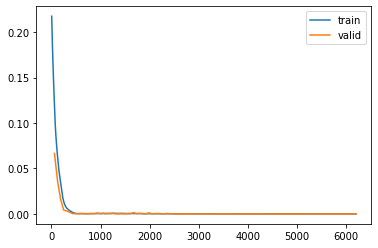

In [11]:
recorder.plot_loss()

The best value for the MSE on the validation set is ~1.6e-6, given by the ELU network without BN, and custom scaling.

In [12]:
learn.validate()

(#1) [1.5920386431389488e-06]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [13]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [14]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = ((10**(df['E'])) + 3.2) * 5
    df['pt'] = ((10**(df['pt'])) + 3.1) * 4.5
    return df


Make the histograms from the dataset...

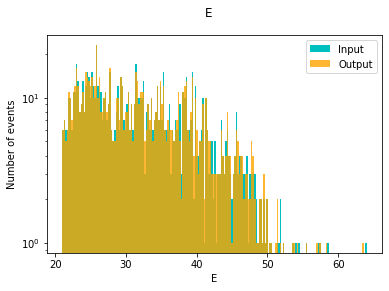

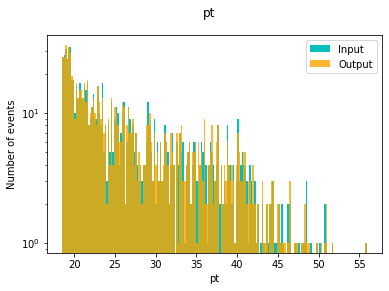

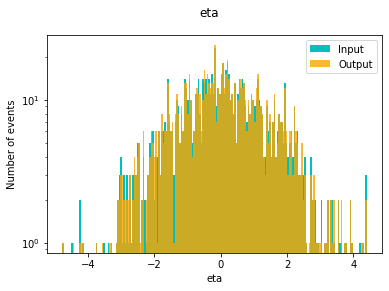

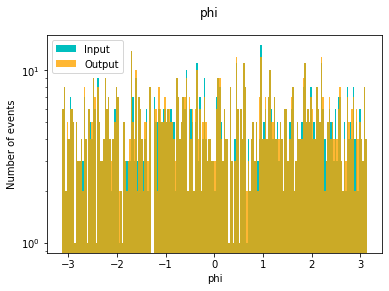

In [15]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad/3]', '[rad/3]', '[GeV]']
variable_list = [ r'$E$', r'$p_T$', r'$\eta$', r'$\phi$',]
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 1000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=branches)
pred_df = pd.DataFrame(pred, columns=branches)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df) 
    
alph = 0.8
n_bins = 200
for kk in range(0, 4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(unnormalized_data_df[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(unnormalized_pred_df[branches[kk]], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [16]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
print(rat)

[0.0, 0.0, 0.0, 0.25, 0.0, -0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3333333333333333, 0.14285714285714285, 0.0, 0.0, 0.0, -0.2, 0.25, 0.0, 0.16666666666666666, 0.0, -0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, -0.16666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.3333333333333333, 0.0, -0.2857142857142857, 0.3333333333333333, 0.1111111111111111, -0.3333333333333333, 0.0, 0.0, 0.0, -0.3333333333333333, 0.25, -0.16666666666666666, 0.5, 0.0, 0.0, 0.0, -0.14285714285714285, 0.2, -0.6, 0.3333333333333333, 0.2, 0.0, -0.16666666666666666, 0.16666666666666666, 0.0, 0.0, 0.2, -0.16666666666666666, 0.0, -0.2, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, -0.1, 0.0, 0.16666666666666666, -0.3333333333333333, 0.2, 0.0, 0.2, -0.09090909090909091, 0.3333333333333333, -0.14285714285714285, 0.0, 0.25, -0.2222222222222222, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, -0.14285714285714285, 0.0, 0.125, -0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0